<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Algorithm-5---Phase-Constrained-Reconstruction-and-the-Virtual-Coil-Concept" data-toc-modified-id="Algorithm-5---Phase-Constrained-Reconstruction-and-the-Virtual-Coil-Concept-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Algorithm 5 - Phase Constrained Reconstruction and the Virtual Coil Concept</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Phantom" data-toc-modified-id="Phantom-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Phantom</a></span></li><li><span><a href="#Low-Resolution-Phase-Estimate" data-toc-modified-id="Low-Resolution-Phase-Estimate-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Low Resolution Phase Estimate</a></span><ul class="toc-item"><li><span><a href="#Define-Virtual-Coil-Matrix" data-toc-modified-id="Define-Virtual-Coil-Matrix-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Define Virtual Coil Matrix</a></span></li><li><span><a href="#Compute-inverse-Fourier-transforms-of-sampled-data" data-toc-modified-id="Compute-inverse-Fourier-transforms-of-sampled-data-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Compute inverse Fourier transforms of sampled data</a></span></li><li><span><a href="#Solve" data-toc-modified-id="Solve-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Solve</a></span></li></ul></li></ul></li></ul></div>

# Algorithm 5 - Phase Constrained Reconstruction and the Virtual Coil Concept

If we consider the problem now just as a general linear inverse problem, we can solve our Partial Fourier reconstruction using similar tools and formulations to those used in Parallel Imaging. In fact, this is precisely one way to combine Partial Fourier/Phase Constraints with Parallel Imaging, if coil sensitivity information is present and being used.

In [1]:
import BrukerMRI as bruker
import pylab as pl
import plot
#Python method of extracting raw Bruker Files
import BrukerMRI as bruker

# Modules
import pandas as pd
import pydicom as dcm
import math
import numpy as np
import matplotlib.pyplot as plt
import glob
from os.path import expanduser
import os
from matplotlib import cm
import cmath

## Functions

In [2]:
def partial_fourier(k_sp,upper_or_lower,percentage):
    k_space = k_sp.copy()
    frac = percentage/100
    k_sp_frac = np.empty(k_sp.shape,dtype ='complex')
    start = 0
    end = 0
    
    if upper_or_lower == "up":
        start = 0
        end = int(frac*(int(k_space.shape[0])))
    
    elif upper_or_lower == "lower":
        start = k_space.shape[0]-int(frac*(int(k_space.shape[0])))
        end = k_space.shape[0]
    
    for i in range(start,end):
        k_sp_frac[i,:] = k_space[i,:]
        
    return k_sp_frac

In [3]:
def img_diff(corrected,original):
    c = np.abs(corrected - np.abs(original));
    return c

In [4]:
def hanning(k_sp):
    
    N_x = k_sp.shape[0]
    N_y = k_sp.shape[1]
    
    for i in range(0,N_y):
        if all(k_sp[i,:] == ((0+0*1j))):
            N_y = i
            break
    
    x = np.linspace(0,N_x,N_x)
    y = np.linspace(0,N_y,N_y)
    xv, yv = np.meshgrid(x,y)
    hanning = 0.5*(1-np.cos(2*np.pi*(yv)/(N_y-1)))
    return hanning

In [5]:
def pf(ksp):
    
    N_x = ksp.shape[0]
    N_y = ksp.shape[1]
    
    for i in range(0,N_x):
        if all(ksp[i,:] == ((0+0*1j))):
            N_y = i
            break
    return N_y

## Phantom

In [6]:
from phantominator import shepp_logan
# MR phantom (returns proton density, T1, and T2 maps)
nx = 96
ny = 96
M0, T1, T2 = shepp_logan((nx, ny,20), MR=True)

In [7]:
### Applying a Phase to a Real Image
nx=96
[x,y,z] = np.meshgrid(range(0,nx),range(0,nx),range(0,20))
phase = np.sqrt(np.power((x-nx/4)/5,2) + np.power((y-nx/6)/10,2))
phase.shape

M1 = M0.copy()
M1_phased = M1 * np.exp(1j*phase)

### Selecting a Single Slice
M1_phased_6 = M1_phased[:,:,6]

### K-Space of Phased Image, M1_Phased
M1_ksp_single = np.fft.fftshift(np.fft.fft2((M1_phased_6)),(0,1))


### 3Q Partial Fourier
M1_ksp_3Q = partial_fourier(M1_ksp_single,'up',74)

### 3Q Partial Fourier
img_3Q = np.fft.ifft2(np.fft.fftshift(M1_ksp_3Q))

Text(0.5, 1.0, 'Image of 3Q PF')

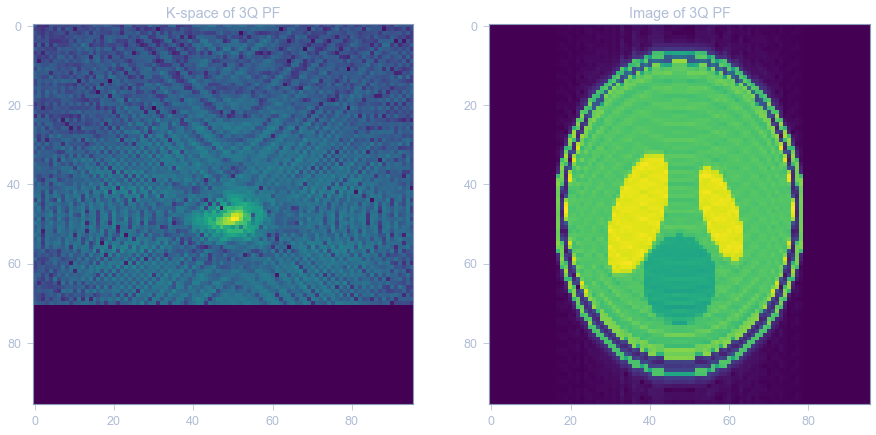

In [8]:
plt.figure(figsize=(15,15))

plt.subplot(121)
plt.imshow(np.log(1+np.abs(M1_ksp_3Q)))
plt.title('K-space of 3Q PF')

plt.subplot(122)
plt.imshow(np.abs(img_3Q))
plt.title('Image of 3Q PF')

## Low Resolution Phase Estimate

In [9]:
hanning = hanning(M1_ksp_3Q)
phs = np.zeros(M1_ksp_3Q.shape, dtype = 'complex')
pf_3q = pf(M1_ksp_3Q)
phs[0:pf_3q,:] = M1_ksp_3Q[0:pf_3q,:]*hanning
phs2 = np.exp(1j*np.angle(np.fft.ifft2(np.fft.fftshift(phs))))

###  Define Virtual Coil Matrix

In [10]:
import scipy as sp
C= np.empty((1,1))
row = np.power(nx,2)
col = np.power(ny,2)
phs_flat = phs2.flatten()

In [11]:
C_1 = sp.sparse.diags(phs_flat,0,shape=(row,col))
C_2 = sp.sparse.diags(np.conj(phs_flat),0,shape=(row,col))

In [12]:
C_1_arr = np.array(C_1.toarray()) 
C_2_arr = np.array(C_2.toarray()) 

In [13]:
C = np.concatenate([C_1_arr,C_2_arr],axis=0)

### Compute inverse Fourier transforms of sampled data

In [14]:
A =  img_3Q
# Image from Conjugate Symmetry from k-space 
B = np.fft.ifft2(np.conj(np.roll(np.flip(np.roll(np.flip(np.fft.fftshift(M1_ksp_3Q),1),1,axis=1)),1,axis=1)))

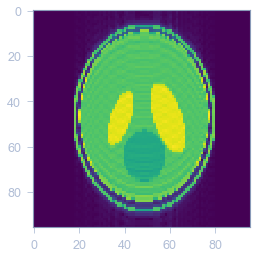

In [15]:
plt.imshow(np.abs(B))

In [16]:
a_b = np.concatenate([A.flatten(),B.flatten()],axis=0)

### Solve

In [17]:
from numpy.linalg import inv
C_p = C.conj().transpose()
#C_p = np.transpose(np.conj(C))

In [18]:
int_1 = C_p @ C

In [19]:
int_2 = inv(int_1)

In [20]:
int_3 = int_2@C_p

In [21]:
img_vc = int_3 @ a_b

In [22]:
img_vc = np.real(img_vc)
img_vc[img_vc < 0] = 0
img_vc = np.reshape(img_vc,(nx,ny))

Text(0.5, 1.0, 'Image of 3Q PF, PCR & VCC')

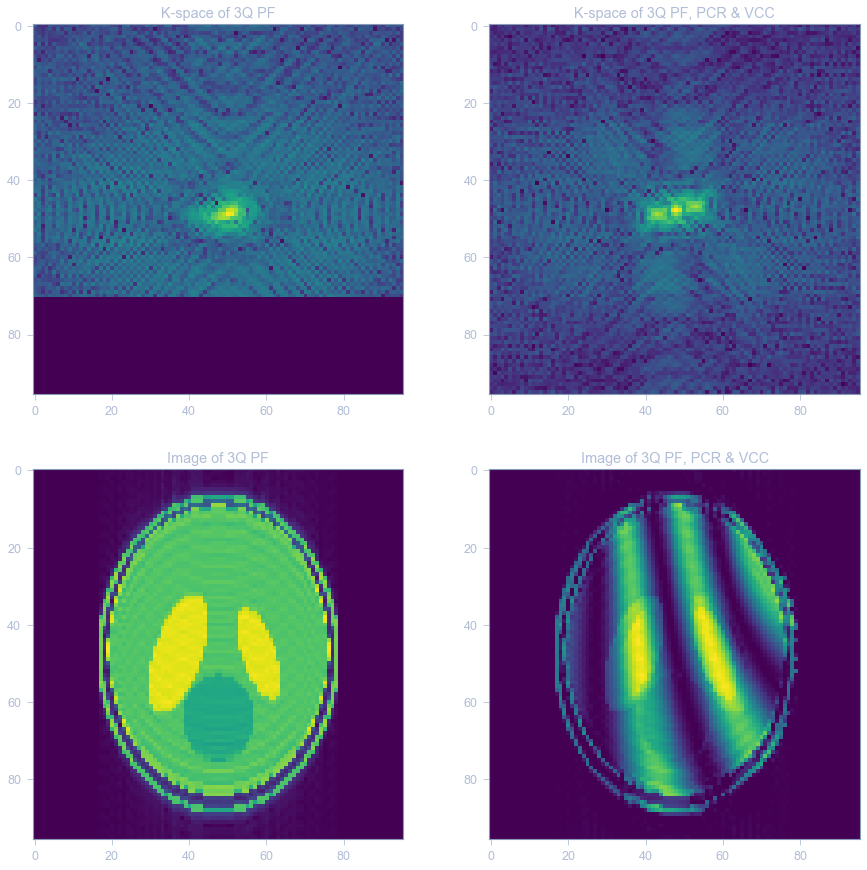

In [23]:
plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(np.log(1+np.abs(M1_ksp_3Q)))
plt.title('K-space of 3Q PF')

plt.subplot(222)
plt.imshow(np.log(1+np.abs(np.fft.fftshift(np.fft.fft2((img_vc))))))
plt.title('K-space of 3Q PF, PCR & VCC')

plt.subplot(223)
plt.imshow(np.abs(img_3Q))
plt.title('Image of 3Q PF')

plt.subplot(224)
plt.imshow(img_vc)
plt.title('Image of 3Q PF, PCR & VCC')